# Q-learning with neural networks

In [5]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
from tqdm import tqdm
from pathlib import Path


import torch

import pendulum

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [6]:
# we define the neural network to be used for Q-learning
# 2 hidden layers with 64 nodes
# 2 inputs (state)
# 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

# we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


# possible controls
possible_controls = np.array([-5., 0., 5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [7]:
x0 = np.zeros((2, 1))


def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(
        x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u


pendulum.animate_robot(x0, controller, push=False, save_movie=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA3pRtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRdliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr4lP
ZQqSz5JJC7+UNk320iVM7FJjmHG6sJrpM/dh0nQ+5r39OQ6RmVrVK1PYH+AOycAUF/b9pFk95XFX
RxCqPJ0AVrNvSkCKxJc2DnGq23y1nGBZ127xxqpU/igQ6yAFvguNC7oG/xZGBYBEohvF6/LewX2a
A+aHL9961Ual9N+JPaEdVqNgZLba5T918fBue/HVYXY24KxL10ijCur/Qlv/AcWwji9ew7mbPIPk
hB4sbRpm2Il9JEqlOnxBFjtq/wKfkNJeUSf9J5P8O4BNTkM1gkZL/wyhJYvT1X0K+Jk0axfEEQyC
iTH7hzm/SxzoncYZIn5BZ8sxRAWesZ+pg7wAFlsTZOi+X9u9nLEzMBtt4zEEgZ+C32PDnZae+ds5
LBI6r/3k2snwp8XCTodng4fYqDVUOgBRMgSMWF09Rjss95a5Zq+j+Yax4Lz7PlABc7azzgAAAwJY
YKOVNMrl6KL56PFo+XNAOJFYk5sHzZRaw9tq65pGNPkyV48tmLE4MR/lYy1BluJ2nSlIFkKgzH50
QXZXMTqb7pdBAMlFlP9AA2i74xZrzWA0Q4OFx4Bb1n/JvrZyxbFQnwWW/v8oPkxv2wXuScDxcgUb
twq5qVH1xf4C+82wLdzNPCoPxP7VBPizkRCgEUI+s1TnIxkPhTM2T0n8ysjIZBi5xRXZVsNGq0Gb
KTz1p8GsMLVOBN5wsZ58REFlh3kQCbgOf/LA+DFXUOi7qxcf0YTuMiPLVRDoEQspo+vmnom2sZ7+
ZCrur6X3ow8bT6WM/Mgzein/6JydwqlEOPpQts4ZJw0Li4uuFRbFKM3cs6DmvEDljpcwCTJrpwl+
3HxGi21mXJ4crF6XflhojcHoLZQNFsTQarP2zoSG7YVyg7gVWSuhW0XZ79CS/kGJnllsLJahewyT
Xr1uSyJ4NrjcqPX0efsefTEhOlTYoSNHtIKNLavE+2AP95Hd2EkPlDbBe79z2sK2GzWNHIZ5KoTB
XE7sZs3X39ul0Rr1O9mWFyxUWyA5XplCcOVZNENClWtOqfp0RnohDiyemJ7Mr2fyvoio0DH1TQ4F
bwXwrYG2r84iG6k2loU5XObNAX21z6j6aCsOaps3mIX5EgXoG2Ft1MmKhnTtvJ9c+x9kH/kqezHv
hnAuSvahzpNIQgQ8dtoSdUcA4T+xgcQJpJmzAE/SKnPB62O/nNI0Dr6f93D5whuwmYs4tMrwxsLa
MXd/MOcT9yxDniqwZwAuJ7OswinGOlhmRpmI7lIfpYAKSl2kYKlMy2ghJA6Ez99iE/I/UIEbB57A
1Oy/ZzUaKyaO0Zg/dWTZIASd3uEex/+sz1VS0JrB3Cxz5vScMBlOKp273Gf7aOaIJ5arlvi/8aQE
+qffFEJf1GQjcAN9Z7z8x0AngDxDcoMtTIZcRfxPiMWt/cJ8IiLMkT3PgNuVqQ5pJZrTECxY+LNy
yQf2g4zmPJtr5nuvVDQvChuo3GAMO3E0YsBnhpwj3bXY70IVL1O5tpV4uHcYPbLNZsxMmW4TF/x7
TfwoaaBM6s+TwghESho/+fLcv5vkaoqZ6COdfg1tFwlQn85W4+5F+m8n1udsHcjLNw1tU1hFpdxH
uBE+pz4bBI65Dsat2UGw28K/nGQ6bWUxZLZ6JOt1u9jbhPJxpB9/l9crS0gumno3PPExkxI+Dp2V
n8pPUf8L5OGz7w+WDjTsrA1BxIdS5FqSrJeHf2z2JOgpgZvvSDPCBPnzDB8l9CbIfVe8XqonTrdD
HAHc2JMvydt7ooPhywMT3k2IXa0blYo0W9i/92pe1Fzk/ZdlXYx7j74qS8iR9ofSHOupZhDA9OPG
CNrSCeQbJj0Mao8PCfJN3ciExND1eKkxMBDFjJfS04SQOYFXqrksjsqTr7K15fnDCsx1MWBR5aP/
MhA1KgajKPpXwH2VW1fum/jPhRrfD8/DtpM67fQd9fyyQxEnNpU3lx8zAZaclryEUguhvw2750+c
+Lk1c8qtt33+frS846IDpw+zVM1E9qjn/MRFeem/ICOW8fO31HDCaTZwKIgsZ6CSP9/h9zeVQz3Z
Z/ACbA+ARavVd6b7qVPkABoCgmMTAhGpBhy885rWCgAKaQAV5FnjYD1eDYOwZg3R9S2t2+nSoBC/
DXnY++zIxnc/pdsi2r0FONd4N1BadotqiNYSmCd3DidAMyDM3+WtkuZU0O+Ll8Rxe0URAGnC6MhW
wGOTw/H1ugTPbkSLQo5YXdss2xl1H1+ThJ0R21T+1vYOiYLaYs46LKzaNa4R/t/WJLXf1vjHFi9+
L5adt42SV6kS2xGmv4N9l9BE3MxHIRxHpPq6ATGxa1+qNVsfONpt3aeO9oJxVqH27ATxO8LkRDyU
7tPNBq7rIYJmy8Px09FcgtE0LUYK4Uq0t5JymGGjMgjGGQQ9mOSN8fxaGTyn8sa/4m97PoL9QnaP
NFO2si/4Xw6CqZL6dseNwE/o5/mRaqNjTeNEk6KyA115vs6xgUnq8G6Jn1RTvbk9f/Hi22P2yqan
IZrBJqv/tHY3MbpSREQi//UR8Xpo93HX2lCnKAQwb0hUXwsufqt6y4rZOPGhkixq8JNCSCc8tFjG
bCZTEOpPQpancW5cD3fCR

## Solution

### Cost function definition - 

We have been given the cost function as 
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$

For this equation, we shall write a function as shown below.

In [8]:
def g(x: np.ndarray, u: float) -> float:
    """
    Compute the immediate cost for a given state and control input in the inverted pendulum system.

    The cost function is defined as:
        g(x, u) = 0.01 * (1 - cos(theta - pi))^2 + 0.001 * theta_dot^2 + 0.00001 * u^2

    This function penalizes:
        - Deviations from the inverted position (theta = pi),
        - Non-zero angular velocity (theta_dot),
        - Large control inputs (u).

    Args:
        x (np.ndarray): State vector of the system.
                        x[0] represents the angle (theta) of the pendulum (in radians),
                        x[1] represents the angular velocity (theta_dot).
        u (float): Control input applied to the system. Allowed values are [-5, 0, 5].

    Returns:
        float: The computed cost associated with the given state and control input.
    """
    return (0.01*((1-np.cos(x[0]-np.pi))**2)) + (0.001 * (x[1]**2)) + (0.00001*(u**2))

### Training Parameter initialisation 

To train the neural network, we must first set the parameters for it. We shall use the following values - 


|Parameter|Variable|Value|
|-|-|-|
|Device|device|'cuda'|
|Numpy Random Seed|np.random.seed|42|
|Torch Random Seed|torch.manual_seed|42|
|Number of time steps per episode|N|100|
|Number of episodes|MAX_ITER|5000|
|Discount Factor|alpha|0.99|
|Learning Rate|lr|0.1|
|$\epsilon$-Greedy Probability|epsilon|0.1|

And we shall write them in code as shown below.

In [9]:
# Make the code device-agnostic by selecting GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the Q-function neural network to the selected device
q_function.to(device=device)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define hyperparameters
N = 100          # Episode length (number of steps per episode)
MAX_ITER = 5000  # Maximum number of iterations for training
alpha = 0.99   # Discount factor for future rewards
lr = 0.1        # Learning rate for the optimizer
epsilon = 0.1   # Exploration rate for the ε-greedy policy

# Initialize the loss function for training (Mean Squared Error)
# Uncomment the following line to use sum reduction instead of the default mean
# loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.MSELoss()

# Initialize the optimizer (Stochastic Gradient Descent) with the Q-network parameters
optimizer = torch.optim.SGD(q_function.parameters(), lr=lr)

# Initialize a list to store the total cost for each episode (useful for visualization)
cost_per_episode: list = []

### Training Loop

To write the training loop, we shall use the example as shown in class. It is easy to memorize using the [ The Unofficial PyTorch Optimization Loop Song ](https://www.youtube.com/watch?v=Nutpusq_AFw) - 

<img src='01-pytorch-optimization-loop-song.png' width="1000">

So, in our case, for each episode, for each time step

1. We do the forward pass to find the optimal control
2. Apply the $\epsilon$-Greedy policy to choose either the optimal control or a random contol
3. Find the next state using the system dynamics
4. Using the current state, control and next state, calculate the total cost-to-go
5. Find the error using the loss function, between the cost-to-go and result of forward pass for the chosen control
6. Perform backpropagation using the loss
7. Update the neural network parameters
8. Make the next step as the current step 
9. Keep track of total cost 

This has been implemented in the code shown below.

In [ ]:
# Choice to train and save or load pre-trained model
# 0 = train and save model; 1 = load pre-trained model
# Change this variable as per requirement. Ensure that file paths are valid.
choice = 0


# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "lipm_q_function.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

if choice == 0:
    # Training loop with progress visualization using tqdm
    for _ in tqdm(range(MAX_ITER), desc='Training in Progress'):
        # Initialize the state vector xi to [0, 0] and move it to the selected device
        xi = torch.tensor(np.zeros((2,)), device=device, dtype=torch.float)

        # Initialize total_cost to accumulate cost per episode
        total_cost = 0

        # Loop over each step within the episode
        for _ in range(N):
            # Perform a forward pass through the Q-network to get Q-values for current state xi
            forward_pass = q_function(xi.unsqueeze(0))  # Shape: [1, 3]

            # ε-greedy policy for action selection
            if torch.rand(1).item() > epsilon:
                # Exploitation: select the action with the minimum Q-value (assuming minimization)
                ui = torch.argmin(forward_pass).item()
            else:
                # Exploration: select a random action from the possible controls
                ui = torch.randint(0, 3, (1,)).item()

            # Compute the next state and target value without tracking gradients
            with torch.no_grad():
                # Apply the selected action to get the next state using the pendulum's dynamics
                xip1 = torch.tensor(pendulum.step(
                    x=xi.cpu().numpy(), u=possible_controls[ui]), device=device, dtype=torch.float)

                # Calculate the target value y_i
                # y_i = g(x_i, u_i) + alpha * min_a Q(x_{i+1}, a)
                yi = torch.tensor((g(x=xi.cpu().numpy(), u=possible_controls[ui]) + (alpha * torch.min(
                    q_function.forward(xip1.unsqueeze(0))).item())), device=device, dtype=torch.float)

            # Compute the loss between the current Q-value and the target y_i
            # forward_pass.squeeze()[ui] extracts the Q-value for the selected action
            loss = loss_fn(forward_pass.squeeze()[ui], yi)

            # Zero the gradients before backpropagation
            optimizer.zero_grad()

            # Perform backpropagation to compute gradients
            loss.backward()

            # Update the Q-network parameters using the optimizer
            optimizer.step()

            # Update the current state to the next state
            xi = xip1

            # Accumulate the cost for the current episode using the cost function g
            total_cost += g(xi.cpu().numpy(), possible_controls[ui])

        # Append the total cost of the current episode to the cost_per_episode list for visualization
        cost_per_episode.append(total_cost)

    # 3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=q_function.state_dict(),  # only saving the state_dict() only saves the models learned parameters
               f=MODEL_SAVE_PATH)
    np.save('cost_per_episode', cost_per_episode)

else:
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    # Load model state dict
    # q_function.load_state_dict(torch.load(
    #     MODEL_SAVE_PATH, map_location=device))

    # # Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
    # q_function.to(device)

    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=torch.device("cpu"))
    q_function.load_state_dict(checkpoint)
    q_function.to(device)

    print(f"Loaded model:\n{q_function}")
    print(f"Model on device:\n{next(q_function.parameters()).device}")

    cost_per_episode = np.load('cost_per_episode')

Training in Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:02<00:00,  5.93it/s]

Saving model to: models/lipm_q_function.pth


### Animation

We shall reuse the same controller function as given above, with the modification of manually setting the device that the q_function runs on. This is to introcude CUDA GPU Acceleration.

In [16]:

# Initial state of pendulum for animation
x0 = np.zeros((2, 1))


def controller(x):
    '''Using the same given controller function with the modification of including the device to run it on.'''
    u_pred = torch.argmin(q_function(torch.as_tensor(
        x, dtype=torch.float, device=device).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u


# Animate the pendulum without external push
pendulum.animate_robot(x0, controller, push=False, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAexJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRJliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07LnY6YnHsOX5sIepwgJjKsAlQNHP/pswOgNHo1QABb0LPkWsFYAAAD
AAADA5Yg+j2rSqIlN/LmgHEisSc2D5sonOO21dc0jGnyZK8eWxUkcGI/ysZagy3E7Te5SBZCoMx/
Ky15hz/WUcDmIJ6nFhT/QANou+MWKo23sVRgo3FPoc8omi1s5YtioT4LLf32Prpv8DlNSbtLxcoD
Cpsa3Wwvm1f4EyoWwLdzNPCoPxPrr11xzkRCgEUI7s1TnIxkPhTM2UhYU0XcYLgngxRXPiNUfJ50
t3DpQPcyHfCB9QeIeRjj+Wp3s91P3xZimf/wwPgxW0bdX243i3LZLiKD3jgPlNNqpclX0vh4Akff
5oMZIRJIhYkZ+NdtApKwK9d1Qz57mshhK+ZFngGlOyuqIgY5ecToJ3PUrx/ZfsAPM2MHakzHXynr
9tgXlWTbnZpNGqHtHevDDhTlOwRAVc3A6//4J7rjrSK92lNBrpnHgLmJzovlEqlk99cHNUGJWtlY
JZj9/ZnsjkOPo6qI9WqoW6sdOVyXEpda1ebAk99LbSv+nGxK71qW0xN3tSwwIsKA82Ht54ZEBUcQ
Z4lp/3KHnETgt72ZYQ8JfABGV6ZQnDlWTRDhaWoRVP06Iz0QhwjmwQAGecna9wp2ZdqNqGxRgKyc
FmNox9gYUMHTMgHFui/a+ojzSqpERgCKMsRwbYz/oG71CLqGXFDYlh1hPHiY/ofHH65GRswwyFNv
kr4B0RXRPfYkqO+2A82dBI/kmn6rXGHYUzu+vmnGwmPtOZnK5vNc9opXnUq5jNQWtQj4W6Jg01lw
FBHDHZTNczQJV1vKdGFoR4p2u8KUs1uGjWEADiFWc1vBv6riaB47NDGax727TVoiWnbaAZ8cIRx9
w2F2Ts+CQALO4AAEnd7hZpyec0iytODThQHtfdDfyFRLhMFg0AlME4Fbv1uRLnn8m+f6+45T1CJU
NNHGfjDWnB6ZesJW7CJ3Rp4qtqHrua7v0ds/YeAcPGaLpKRLdwkeGFatYE1g+8b9eei5txtUnekr
7zyGcj4j+OHOkEjr0AS3MyWhuN2fQyxU2pitPMW088Sl5GiOumgQCvpEk0evGcBlcZlbZfgys5o1
tVqN7HTDVHX5QIw0MOEM6SgruuE9CvwMvHO/8U91tm6F3aduPTp0ViUa2DQh7YS8uVPeMcs3Kl8u
Wwqzo5rRbTEXgTPZ4IEccjRna2sTGms2CTOvY3AVZXalgqUhrJH2ouLQ+ohj7C11R6stbexW+lY3
74BJHPk9G579pfj6Nk0WbKaz8LWPObSsu7UJOuYWSFQyk1DXsTkaypBMXeqRdlWyT3deZdrsV/bR
bm/cjyrzb7BjZm6zfddZm4Fpm2UdMj0RNXD+oenenrYRAH6sR1mdE8lM0lxCMuyM9l2/EAli6uEe
UvxBSfTiCZrb49Wz0fvD+Oc860eG4z1N/a23X8lAIqG57SSxcya8BgrIPX72cix6tBF3oIRVK2xu
4xgkJWhD3i/n/g5tqLvof40dPDuVLoZwDhfHuxCTItmv/Csr3/JWMjuH/tM4x4Cz2BfsbYewuQDg
saf4JolmiSiH4JEJXFqtpnDt4v6p3+GdKtoKKJ7XhSJlC+PTjFt1poAnEEVsyE2wsfXMpB9lGQy2
yKbmuA60pOBIF894JKGgCMlAjgSNpB5VAAIvUWpIf1A2NFhcMuS8AcDzkj7rwCYAAAMAAMGsBbJK
bnAodezBGQ0B9hwV8kQlg/Oc4U4A0Ju6kwEM8uZ9HkJC/aDP0OUCBQ0CMesm7TAO2X9fDbG/pUSy
kVyPCIkdU+uD9FWGAUrDvDKwXb5rIzcDcKjPPAqZ2qQWZuBoEQek4Xh7Clt4iPhO/8eMKYYOCbxz
y/eHCPRu6nnc7WwO6hhRNDGeu57RNWoeL09OfziNK7Gex/TOYyqjVbHy4kjURaGtNRa3FHTOwE8T
vCfYFRnc0VL+6u6yGCZlZzU2Z4buq0yQj/wFX2opFjfqH8YjdaijM367HJG+P4tDJ5UFMsysqc/t
gc8SIUab9XSApbZjw6CqZL6dseNwE/jV/qhI27zdrrK+3HE+VrKySsYEo3XPESF8agSGDSTGdEvd
eItBt2dhDrPkWEPf/iXMKqYWcPODZI0WS5G2UcNcgvUaFSCZSppE0QKm0C88uzA7SaxMfQfwEuQc
jQGY5lRpbIpDaGRPnV4vx

In [17]:
# Animate the pendulum with external push
pendulum.animate_robot(x0, controller, push=True, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAnuVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRJliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07LnY6YnHsOX5sIepwgJjKsAlQNHP/pswOgNHo1QABb0LPkWsFYAAAD
AAADA5Yg+j2rSqIlN/LmgHEisSc2D5sonOO21dc0jGnyZK8eWxUkcGI/ysZagy3E7Te5SBZCoMx/
Ky15hz/WUcDmIJ6nFhT/QANou+MWKo23sVRgo3FPoc8omi1s5YtioT4LLf32Prpv8DlNSbtLxcoD
Cpsa3Wwvm1f4EyoWwLdzNPCoPxPrr11xzkRCgEUI7s1TnIxkPhTM2UhYU0XcYLgngxRXPiNUfJ50
t3DpQPcyHfCB9QeIeRjj+Wp3s91P3xZimf/wwPgxW0bdX243i3LZLiKD3jgPlNNqpclX0vh4Akff
5oMZIRJIhYkZ+NdtApKwK9d1Qz57mshhK+ZFngGlOyuqIgY5ecToJ3PUrx/ZfsAPM2MHakzHXynr
9tgXlWTbnZpNGqHtHevDDhTlOwRAVc3A6//4J7rjrSK92lNBrpnHgLmJzovlEqlk99cHNUGJWtlY
JZj9/ZnsjkOPo6qI9WqoW6sdOVyXEpda1ebAk99LbSv+nGxK71qW0xN3tSwwIsKA82Ht54ZEBUcQ
Z4lp/3KHnETgt72ZYQ8JfABGV6ZQnDlWTRDhaWoRVP06Iz0QhwjmwQAGecna9wp2ZdqNqGxRgKyc
FmNox9gYUMHTMgHFui/a+ojzSqpERgCKMsRwbYz/oG71CLqGXFDYlh1hPHiY/ofHH65GRswwyFNv
kr4B0RXRPfYkqO+2A82dBI/kmn6rXGHYUzu+vmnGwmPtOZnK5vNc9opXnUq5jNQWtQj4W6Jg01lw
FBHDHZTNczQJV1vKdGFoR4p2u8KUs1uGjWEADiFWc1vBv6riaB47NDGax727TVoiWnbaAZ8cIRx9
w2F2Ts+CQALO4AAEnd7hZpyec0iytODThQHtfdDfyFRLhMFg0AlME4Fbv1uRLnn8m+f6+45T1CJU
NNHGfjDWnB6ZesJW7CJ3Rp4qtqHrua7v0ds/YeAcPGaLpKRLdwkeGFatYE1g+8b9eei5txtUnekr
7zyGcj4j+OHOkEjr0AS3MyWhuN2fQyxU2pitPMW088Sl5GiOumgQCvpEk0evGcBlcZlbZfgys5o1
tVqN7HTDVHX5QIw0MOEM6SgruuE9CvwMvHO/8U91tm6F3aduPTp0ViUa2DQh7YS8uVPeMcs3Kl8u
Wwqzo5rRbTEXgTPZ4IEccjRna2sTGms2CTOvY3AVZXalgqUhrJH2ouLQ+ohj7C11R6stbexW+lY3
74BJHPk9G579pfj6Nk0WbKaz8LWPObSsu7UJOuYWSFQyk1DXsTkaypBMXeqRdlWyT3deZdrsV/bR
bm/cjyrzb7BjZm6zfddZm4Fpm2UdMj0RNXD+oenenrYRAH6sR1mdE8lM0lxCMuyM9l2/EAli6uEe
UvxBSfTiCZrb49Wz0fvD+Oc860eG4z1N/a23X8lAIqG57SSxcya8BgrIPX72cix6tBF3oIRVK2xu
4xgkJWhD3i/n/g5tqLvof40dPDuVLoZwDhfHuxCTItmv/Csr3/JWMjuH/tM4x4Cz2BfsbYewuQDg
saf4JolmiSiH4JEJXFqtpnDt4v6p3+GdKtoKKJ7XhSJlC+PTjFt1poAnEEVsyE2wsfXMpB9lGQy2
yKbmuA60pOBIF894JKGgCMlAjgSNpB5VAAIvUWpIf1A2NFhcMuS8AcDzkj7rwCYAAAMAAMGsBbJK
bnAodezBGQ0B9hwV8kQlg/Oc4U4A0Ju6kwEM8uZ9HkJC/aDP0OUCBQ0CMesm7TAO2X9fDbG/pUSy
kVyPCIkdU+uD9FWGAUrDvDKwXb5rIzcDcKjPPAqZ2qQWZuBoEQek4Xh7Clt4iPhO/8eMKYYOCbxz
y/eHCPRu6nnc7WwO6hhRNDGeu57RNWoeL09OfziNK7Gex/TOYyqjVbHy4kjURaGtNRa3FHTOwE8T
vCfYFRnc0VL+6u6yGCZlZzU2Z4buq0yQj/wFX2opFjfqH8YjdaijM367HJG+P4tDJ5UFMsysqc/t
gc8SIUab9XSApbZjw6CqZL6dseNwE/jV/qhI27zdrrK+3HE+VrKySsYEo3XPESF8agSGDSTGdEvd
eItBt2dhDrPkWEPf/iXMKqYWcPODZI0WS5G2UcNcgvUaFSCZSppE0QKm0C88uzA7SaxMfQfwEuQc
jQGY5lRpbIpDaGRPnV4vx

### Plots

Finally we shall plot the results, as shown below.

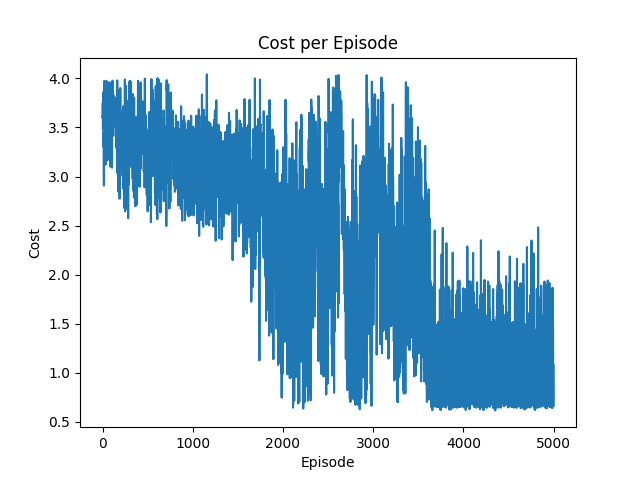

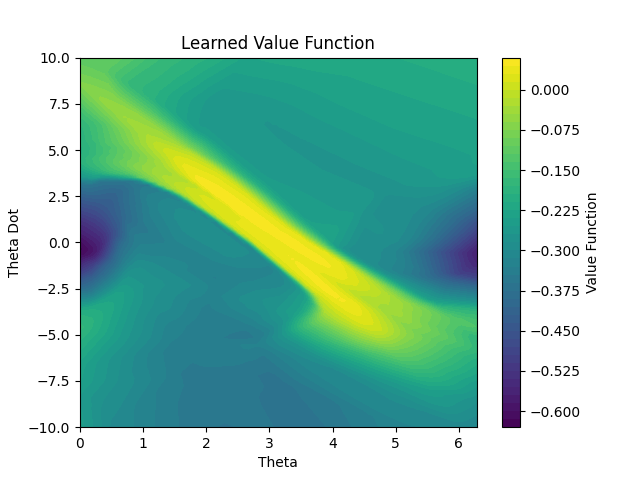

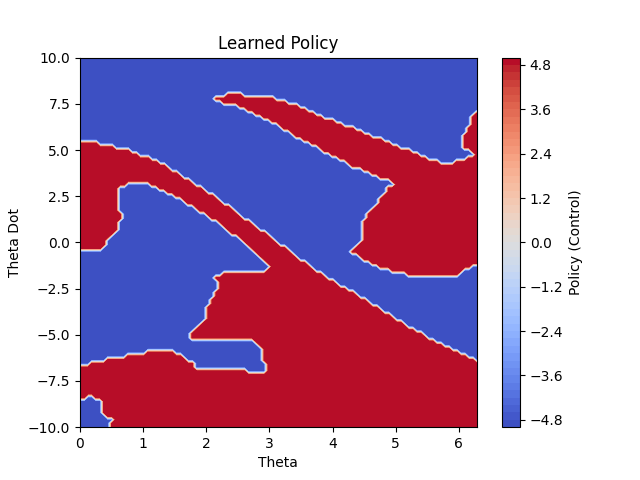

In [13]:
# Plot cost per episode
plt.figure()
plt.plot(cost_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.title('Cost per Episode')
plt.show()

# Plot learned value function and policy
theta_vals = np.linspace(0, 2 * np.pi, 100)
theta_dot_vals = np.linspace(-10, 10, 100)
Theta, ThetaDot = np.meshgrid(theta_vals, theta_dot_vals)

ValueFunction = np.zeros_like(Theta)
Policy = np.zeros_like(Theta)

with torch.no_grad():
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            xi = torch.tensor([Theta[i, j], ThetaDot[i, j]],
                              device=device, dtype=torch.float)
            q_values = q_function(xi.unsqueeze(0)).cpu().numpy().squeeze()
            # Negative because it's a cost
            ValueFunction[i, j] = -np.min(q_values)
            Policy[i, j] = possible_controls[np.argmin(q_values)]

# Plot the value function
plt.figure()
plt.contourf(Theta, ThetaDot, ValueFunction, levels=50, cmap='viridis')
plt.colorbar(label='Value Function')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Value Function')
plt.show()

# Plot the policy
plt.figure()
plt.contourf(Theta, ThetaDot, Policy, levels=50, cmap='coolwarm')
plt.colorbar(label='Policy (Control)')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Policy')
plt.show()